# LSTM and GRU with cortical electrophys
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

Run the first three cells to normalize Local / Colab environments, then proceed below for the lesson.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-alpha0
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

# Additional imports
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from indl import enable_plotly_in_cell
%load_ext tensorboard.notebook

In [3]:
# Download and unzip data (3.4 GB)
datadir = Path.cwd() / 'data' / 'joeyo'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted')} cboulay/joeyo_nhp_reach_mea
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Prepare Data

### Import

In [26]:
from data.utils.fileio import load_joeyo_reaching
sess_names = ['indy_2016' + _ for _ in ['0921_01', '0927_04', '0927_06', '0930_02', '0930_05' '1005_06' '1006_02']]
sess_name = sess_names[0]
# TODO: No z-score on load. We'll z-score with training mean/sd only.
X, Y, X_ax_info, Y_ax_info = load_joeyo_reaching(datadir, sess_name, x_chunk='spikerates')
assert X_ax_info['fs'] == Y_ax_info['fs']
# TODO: If we want to use LFP data (1 kHz) we need to downsample it or upsample behaviour (250 Hz)

### Prepare for TensorFlow

Y has finger position (3-D), cursor position (2-D; direct projection of finger position), and the target position. We need only the cursor position, so we select only those channels from Y.

Both X and Y come in shape (channels, samples) as float64. We need them in (segments, samples, channels) as float32.

Finally, we split into training and validation sets, shuffling the training data, and batching both.

In [27]:
from sklearn.model_selection import train_test_split
SEQ_DUR = 1.0
P_TRAIN = 0.8
BATCH_SIZE = 5
behav_chans = ['CursorX', 'CursorY']

seq_length = int(SEQ_DUR * X_ax_info['fs'])

# Slice Y to only keep required behaviour data.
b_keep_y_chans = np.in1d(Y_ax_info['channel_names'] , behav_chans)
Y = Y[b_keep_y_chans, :]

# Segment X and Y into sequences of length seq_length. Also convert to 32-bit and transpose to get channels last.
n_drop = X.shape[-1] % seq_length
X = X[:, :-n_drop].astype(np.float32).reshape((X.shape[0], -1, seq_length)).transpose((1, 2, 0))
Y = Y[:, :-n_drop].astype(np.float32).reshape((Y.shape[0], -1, seq_length)).transpose((1, 2, 0))
n_trials = X.shape[0]  # Not really 'trials', more like 'sequences'

# DON'T DO THIS! It randomizes training so they don't carry over.
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size=P_TRAIN)

ds_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

# use shuffling as long as stateful doesn't work.
ds_train = ds_train.shuffle(int(n_trials * P_TRAIN) + 1)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE)

## Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU)
[This blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) from mid-2015 is still one of the best explanations of LSTMs around. The short of it is that each LSTM cell has three functions or 'gates' that decide (on each step) how much of the state (forget gate) gets combined with how much of the input (update gate) to make the new state, and how much of the input gets combined with the state to make the output (output gate).

GRUs are similar in concept but use only two gates: an update gate and a reset gate. [See here](https://arxiv.org/pdf/1412.3555v1.pdf).

As such, LSTMs are slightly more sophisticated and theoretically could model more of your model space, but in practice GRUs usually do just as well and are more efficient computationally. We will quickly try each version.

### Other studies

* [Ahmadi et al]() - Using one of these datasets.
    * 
* [Glaser et al., arxiv 2018](https://arxiv.org/abs/1708.00909) [with code!](https://github.com/KordingLab/Neural_Decoding)
    * 
* [Park and Kim, IEEE APSIPA ASC 2018](https://ieeexplore.ieee.org/abstract/document/8659760)
* [Tseng et al... Nicolelis, IEEE Neural Computation 2019](https://www.mitpressjournals.org/doi/abs/10.1162/neco_a_01189)
    * "1000 iterations of training with a batch size of 64 and unrolling of 30 steps (equivalent to 1.5 s as each time step was 50 ms)".    
    * Tested 1-layer and 2-layer networks, 2-layer widening was best, with dropout=0.2
* [Wang et al., EMBC 2018](https://ieeexplore.ieee.org/abstract/document/8512609) - Decoding hindlimb kinematics.
    * seq_length=3; N_RNN_UNITS=200; lr=0.001; neural_dropout=0.2; batch_size=32; epochs=100

### Implementation Details
This will probably change, but the unification of LSTM APIs in TensorFlow 2.0 means that there are some constraints on how an LSTM can be parameterized and still run on the GPU.

1. activation == 'tanh'
2. recurrent_activation == 'sigmoid'
3. recurrent_dropout == 0
4. unroll is False
5. use_bias is True
6. No use of masking.

In [30]:
N_RNN_UNITS = 100
inputs = tf.keras.layers.Input(shape=(seq_length, X.shape[-1]))  # Note: batch_shape, not shape, if using stateful
_y = tf.keras.layers.LSTM(N_RNN_UNITS, return_sequences=True)(inputs)  # Why doesn't stateful work?
outputs = tf.keras.layers.Conv1D(2, 1, activation='relu')(_y)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='NAdam', loss='mean_squared_error')
model.summary()


# model.add(LSTM(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout
#     if self.dropout!=0: model.add(Dropout(self.dropout)) #Dropout some units (recurrent layer output units)
        

W0604 18:12:07.251312 11076 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x000002188379AA90>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 250, 257)]        0         
_________________________________________________________________
unified_lstm_14 (UnifiedLSTM (None, 250, 100)          143200    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 250, 2)            202       
Total params: 143,402
Trainable params: 143,402
Non-trainable params: 0
_________________________________________________________________


In [31]:
EPOCHS = 50
history = model.fit(x=ds_train, epochs=EPOCHS, verbose=1, validation_data=ds_valid)

Epoch 1/50
57/57 [==============================] - ETA: 52s - loss: 1.62 - ETA: 10s - loss: 1.11 - ETA: 5s - loss: 1.0726 - ETA: 3s - loss: 1.036 - ETA: 2s - loss: 1.045 - ETA: 2s - loss: 1.009 - ETA: 1s - loss: 0.978 - ETA: 1s - loss: 0.988 - ETA: 1s - loss: 0.962 - ETA: 0s - loss: 0.961 - ETA: 0s - loss: 0.932 - ETA: 0s - loss: 0.920 - ETA: 0s - loss: 0.928 - ETA: 0s - loss: 0.932 - 2s 35ms/step - loss: 0.9288 - val_loss: 0.9437
Epoch 2/50
57/57 [==============================] - ETA: 2s - loss: 1.064 - ETA: 1s - loss: 0.750 - ETA: 0s - loss: 0.751 - ETA: 0s - loss: 0.731 - ETA: 0s - loss: 0.732 - ETA: 0s - loss: 0.715 - ETA: 0s - loss: 0.704 - ETA: 0s - loss: 0.717 - ETA: 0s - loss: 0.704 - ETA: 0s - loss: 0.705 - ETA: 0s - loss: 0.683 - ETA: 0s - loss: 0.675 - ETA: 0s - loss: 0.692 - ETA: 0s - loss: 0.697 - 1s 18ms/step - loss: 0.6977 - val_loss: 0.8782
Epoch 3/50
57/57 [==============================] - ETA: 2s - loss: 0.943 - ETA: 1s - loss: 0.623 - ETA: 0s - loss: 0.640 - ETA: 

57/57 [==============================] - ETA: 2s - loss: 0.792 - ETA: 1s - loss: 0.476 - ETA: 0s - loss: 0.506 - ETA: 0s - loss: 0.490 - ETA: 0s - loss: 0.476 - ETA: 0s - loss: 0.472 - ETA: 0s - loss: 0.472 - ETA: 0s - loss: 0.485 - ETA: 0s - loss: 0.472 - ETA: 0s - loss: 0.478 - ETA: 0s - loss: 0.459 - ETA: 0s - loss: 0.451 - ETA: 0s - loss: 0.473 - ETA: 0s - loss: 0.485 - 1s 17ms/step - loss: 0.4847 - val_loss: 0.8466
Epoch 20/50
57/57 [==============================] - ETA: 2s - loss: 0.794 - ETA: 1s - loss: 0.477 - ETA: 0s - loss: 0.507 - ETA: 0s - loss: 0.491 - ETA: 0s - loss: 0.476 - ETA: 0s - loss: 0.472 - ETA: 0s - loss: 0.472 - ETA: 0s - loss: 0.485 - ETA: 0s - loss: 0.472 - ETA: 0s - loss: 0.478 - ETA: 0s - loss: 0.459 - ETA: 0s - loss: 0.451 - ETA: 0s - loss: 0.473 - ETA: 0s - loss: 0.485 - 1s 17ms/step - loss: 0.4846 - val_loss: 0.8429
Epoch 21/50
57/57 [==============================] - ETA: 2s - loss: 0.792 - ETA: 0s - loss: 0.477 - ETA: 0s - loss: 0.506 - ETA: 0s - loss:

57/57 [==============================] - ETA: 2s - loss: 0.793 - ETA: 1s - loss: 0.475 - ETA: 0s - loss: 0.504 - ETA: 0s - loss: 0.488 - ETA: 0s - loss: 0.475 - ETA: 0s - loss: 0.471 - ETA: 0s - loss: 0.471 - ETA: 0s - loss: 0.483 - ETA: 0s - loss: 0.470 - ETA: 0s - loss: 0.476 - ETA: 0s - loss: 0.456 - ETA: 0s - loss: 0.448 - ETA: 0s - loss: 0.470 - ETA: 0s - loss: 0.483 - 1s 17ms/step - loss: 0.4824 - val_loss: 0.8318
Epoch 38/50
57/57 [==============================] - ETA: 2s - loss: 0.792 - ETA: 1s - loss: 0.475 - ETA: 0s - loss: 0.505 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.475 - ETA: 0s - loss: 0.478 - ETA: 0s - loss: 0.474 - ETA: 0s - loss: 0.483 - ETA: 0s - loss: 0.477 - ETA: 0s - loss: 0.483 - ETA: 0s - loss: 0.465 - ETA: 0s - loss: 0.446 - ETA: 0s - loss: 0.467 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.481 - 1s 19ms/step - loss: 0.4826 - val_loss: 0.8330
Epoch 39/50
57/57 [==============================] - ETA: 2s - loss: 0.792 - ETA: 1s - loss: 0.475 - ETA: 0s - loss:

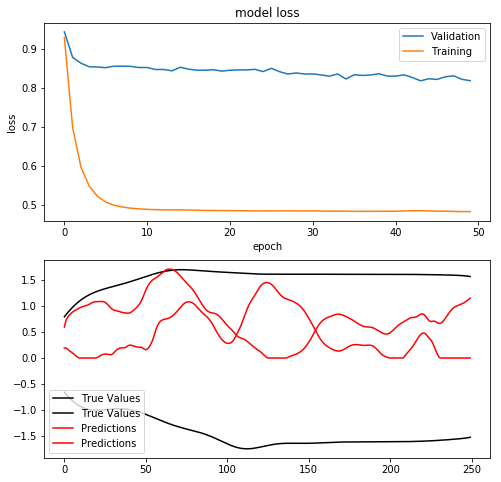

In [32]:
fig = plt.figure(figsize=(8, 8), facecolor='white')
plt.subplot(2, 1, 1)
plt.plot(history.history['val_loss'], label='Validation')
plt.plot(history.history['loss'], label='Training')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.subplot(2, 1, 2)
pred_y = model.predict(x=X_valid[0][None, :, :])
plt.plot(Y_valid[0], 'k', label='True Values')
plt.plot(pred_y[0], 'r', label='Predictions')
plt.legend()
plt.show()